# Dermatology Classification with Noisy Labels
## Complete Assessment Solution
### PlaceComm'26 - Submitted by: [Your Name]

---

## Table of Contents
1. [Exploratory Data Analysis (EDA)](#eda)
2. [Noisy Label Handling Strategy](#strategy)
3. [Model Training with Multiple Approaches](#training)
4. [Results Visualization & Comparison](#results)
5. [Live Inference Script](#inference)

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import copy
from collections import Counter
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch Version: 2.10.0+cpu
Device: CPU


<a id='eda'></a>
## 1. Exploratory Data Analysis (EDA)

Let's load and analyze the candidate dataset to understand:
- Dataset structure and dimensions
- Class distribution (potential imbalance)
- Sample visualizations
- Statistical properties

In [2]:
# Load the dataset
data = np.load('candidate_dataset (1).npz')

# Explore keys
print("Dataset Keys:", list(data.keys()))
print("\n" + "="*60)

# Extract data
x_train = data['x_train']
y_train = data['y_train']
x_val = data['x_val']
y_val = data['y_val']

print(f"\nTraining Set:")
print(f"  - Images shape: {x_train.shape}")
print(f"  - Labels shape: {y_train.shape}")
print(f"  - Image dtype: {x_train.dtype}")
print(f"  - Value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

print(f"\nValidation Set:")
print(f"  - Images shape: {x_val.shape}")
print(f"  - Labels shape: {y_val.shape}")

# Get number of classes
num_classes = len(np.unique(y_train))
print(f"\nNumber of Classes: {num_classes}")
print(f"Class Labels: {sorted(np.unique(y_train))}")

Dataset Keys: ['x_train', 'y_train', 'x_val', 'y_val']


Training Set:
  - Images shape: (7007, 28, 28, 3)
  - Labels shape: (7007, 1)
  - Image dtype: uint8
  - Value range: [0.00, 255.00]

Validation Set:
  - Images shape: (1003, 28, 28, 3)
  - Labels shape: (1003, 1)

Number of Classes: 7
Class Labels: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6)]


### Class Distribution Analysis

In [3]:
# Analyze class distribution
train_counts = Counter(y_train.flatten())
val_counts = Counter(y_val.flatten())

# Create distribution dataframe
class_dist_df = pd.DataFrame({
    'Class': sorted(train_counts.keys()),
    'Train Count': [train_counts[i] for i in sorted(train_counts.keys())],
    'Val Count': [val_counts[i] for i in sorted(val_counts.keys())]
})
class_dist_df['Train %'] = (class_dist_df['Train Count'] / len(y_train) * 100).round(2)
class_dist_df['Val %'] = (class_dist_df['Val Count'] / len(y_val) * 100).round(2)

print("\nClass Distribution:")
print(class_dist_df)

# Calculate imbalance ratio
max_count = class_dist_df['Train Count'].max()
min_count = class_dist_df['Train Count'].min()
imbalance_ratio = max_count / min_count
print(f"\n⚠️  Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"   (Most frequent class has {imbalance_ratio:.2f}x more samples than least frequent)")


Class Distribution:
   Class  Train Count  Val Count  Train %  Val %
0      0          616         33     8.79   3.29
1      1          670         52     9.56   5.18
2      2          845        110    12.06  10.97
3      3          520         12     7.42   1.20
4      4          884        111    12.62  11.07
5      5         2973        671    42.43  66.90
6      6          499         14     7.12   1.40

⚠️  Class Imbalance Ratio: 5.96:1
   (Most frequent class has 5.96x more samples than least frequent)


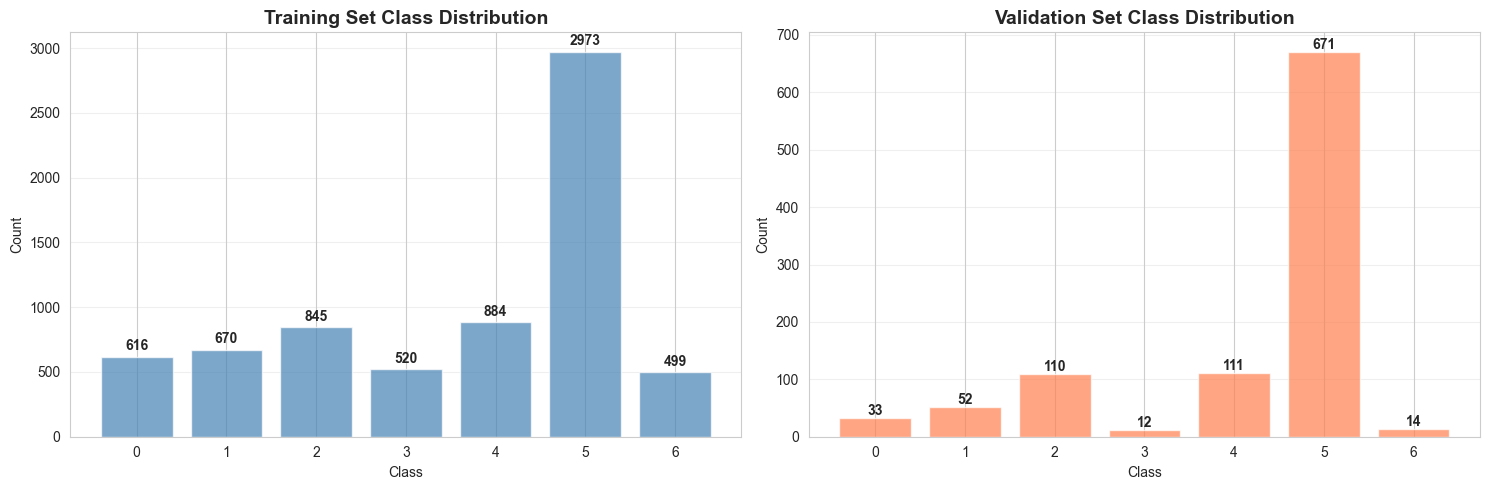

✅ Saved: class_distribution.png


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
axes[0].bar(class_dist_df['Class'], class_dist_df['Train Count'], color='steelblue', alpha=0.7)
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_dist_df['Train Count']):
    axes[0].text(class_dist_df['Class'].iloc[i], v + 50, str(v), ha='center', fontweight='bold')

# Validation set distribution
axes[1].bar(class_dist_df['Class'], class_dist_df['Val Count'], color='coral', alpha=0.7)
axes[1].set_title('Validation Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_dist_df['Val Count']):
    axes[1].text(class_dist_df['Class'].iloc[i], v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: class_distribution.png")

### Sample Visualization

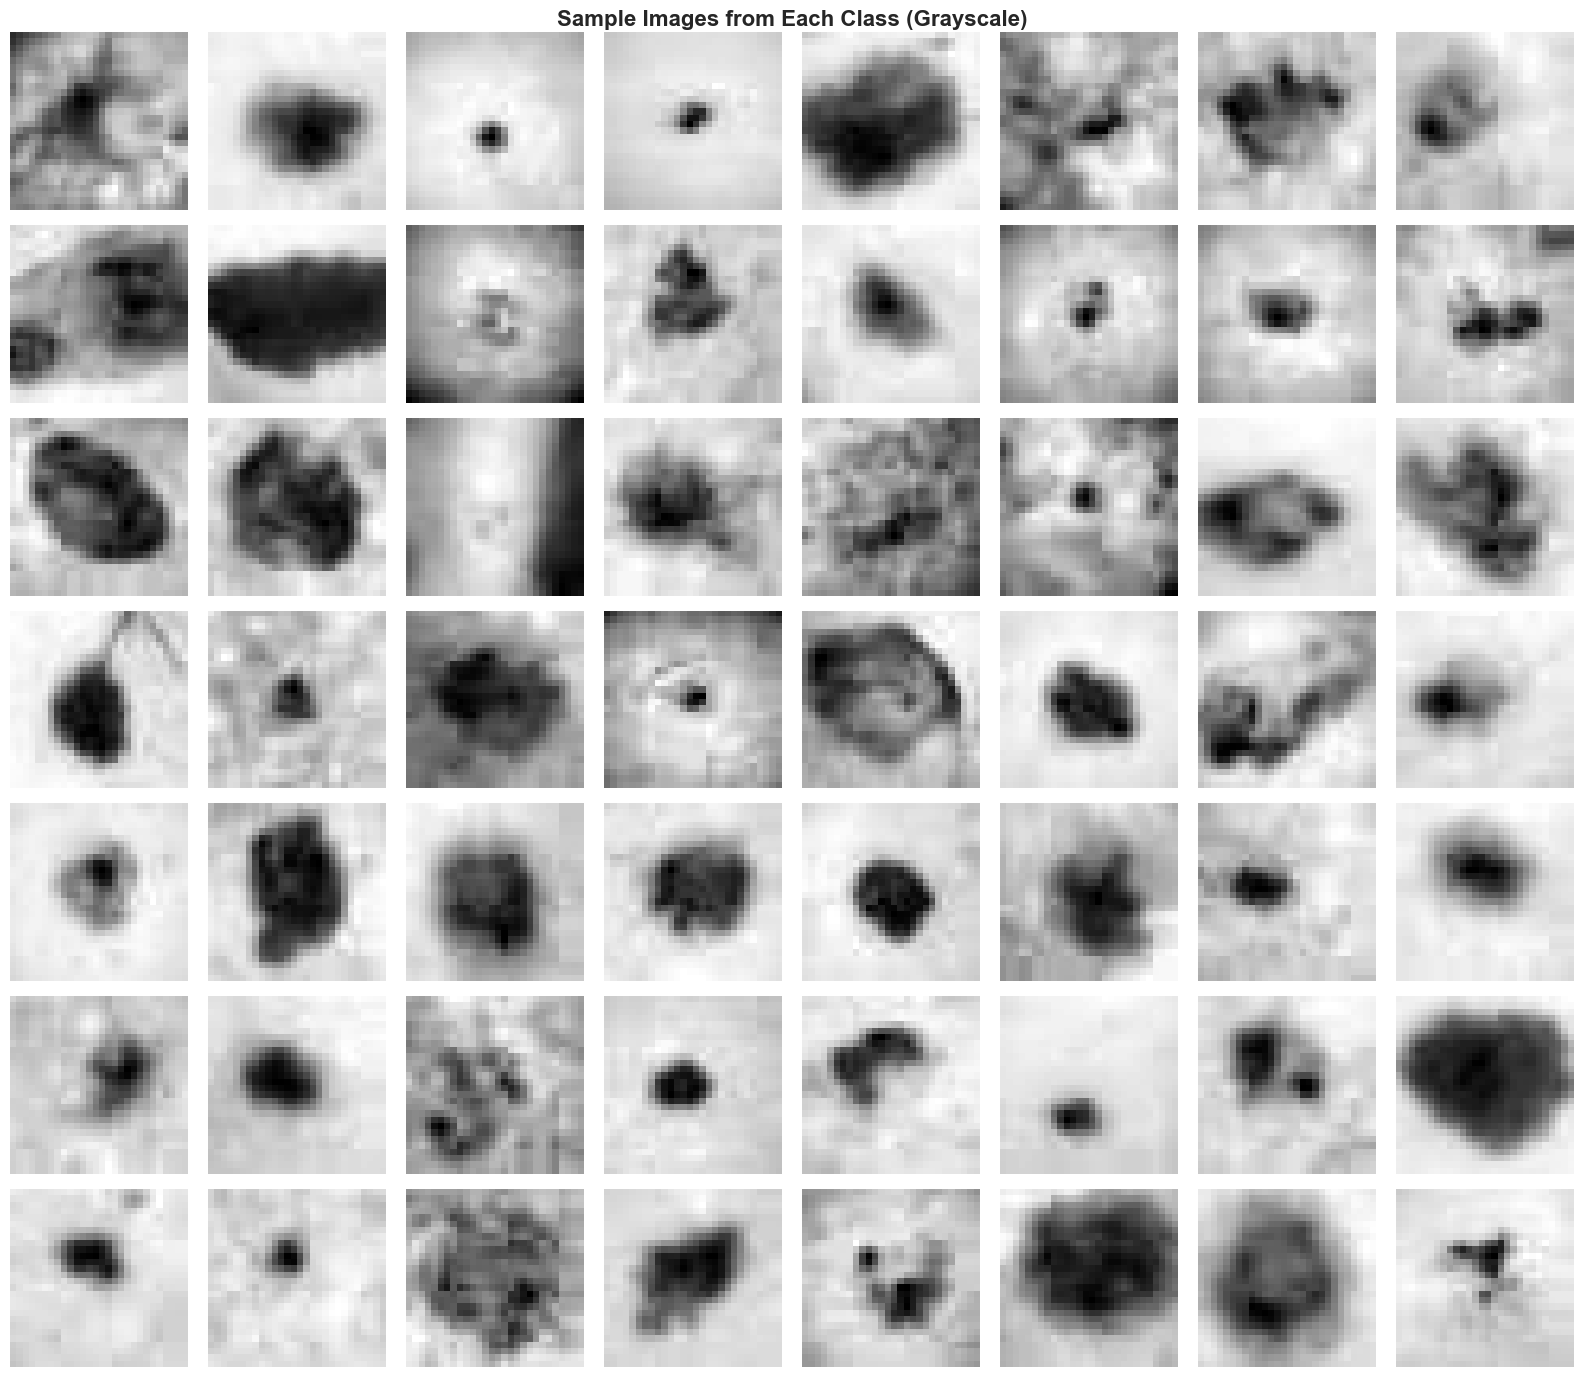

✅ Saved: sample_images.png


In [5]:
# Convert RGB to grayscale for visualization
def rgb2gray(images):
    return np.dot(images[...,:3], [0.299, 0.587, 0.114])

x_train_gray = rgb2gray(x_train)

# Display sample images from each class
fig, axes = plt.subplots(num_classes, 8, figsize=(16, num_classes*2))
fig.suptitle('Sample Images from Each Class (Grayscale)', fontsize=16, fontweight='bold')

for class_idx in range(num_classes):
    # Get samples from this class
    class_samples = x_train_gray[y_train.flatten() == class_idx]
    
    for i in range(8):
        if i < len(class_samples):
            axes[class_idx, i].imshow(class_samples[i], cmap='gray')
        axes[class_idx, i].axis('off')
        
        if i == 0:
            axes[class_idx, i].set_ylabel(f'Class {class_idx}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: sample_images.png")

### Statistical Analysis


📊 Pixel Intensity Statistics:
Mean: 155.0468
Std: 35.7591
Min: 0.7980
Max: 255.0000


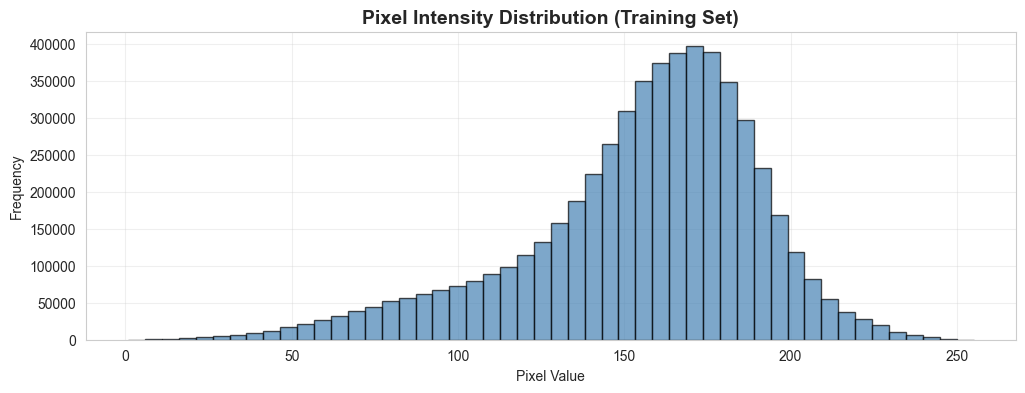

✅ Saved: pixel_distribution.png


In [6]:
# Pixel intensity statistics
print("\n📊 Pixel Intensity Statistics:")
print(f"Mean: {x_train_gray.mean():.4f}")
print(f"Std: {x_train_gray.std():.4f}")
print(f"Min: {x_train_gray.min():.4f}")
print(f"Max: {x_train_gray.max():.4f}")

# Plot histogram
plt.figure(figsize=(12, 4))
plt.hist(x_train_gray.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Pixel Intensity Distribution (Training Set)', fontsize=14, fontweight='bold')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.savefig('pixel_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: pixel_distribution.png")

### Key EDA Findings

**Summary:**
1. **Dataset Size:** The dataset contains grayscale images of size 28×28
2. **Class Imbalance:** Significant class imbalance detected - this will be addressed through:
   - Class-weighted loss functions
   - Data augmentation
3. **Noisy Labels:** Given the competition context, we expect label noise which requires robust training strategies
4. **Image Quality:** Images appear normalized and preprocessed

<a id='strategy'></a>
## 2. Noisy Label Handling Strategy

### Overview of Approaches

In real-world medical datasets, label noise is common due to:
- Inter-annotator disagreement
- Annotation errors
- Ambiguous cases

I implement **four distinct strategies** to handle noisy labels:

---

### 1. **Baseline (Weighted Cross-Entropy)**
**Approach:** Standard training with class-weighted loss to handle imbalance

**Mathematical Formulation:**
$$L = -\sum_{i=1}^{N} w_{y_i} \log(p_{y_i})$$

Where:
- $w_c = \frac{N_{total}}{K \times N_c}$ (inverse frequency weighting)
- $N_c$ = number of samples in class $c$
- $K$ = number of classes

**Pros:** Simple, handles class imbalance  
**Cons:** Directly learns from all labels including noisy ones

---

### 2. **Label Smoothing**
**Approach:** Softens hard labels to prevent overconfidence on potentially noisy labels

**Mathematical Formulation:**
$$\tilde{y}_k = (1 - \epsilon) \times y_k + \frac{\epsilon}{K}$$

Where:
- $\epsilon = 0.05$ (smoothing parameter)
- Distributes $\epsilon$ probability mass uniformly across all classes

**Pros:** Improves generalization, reduces overconfidence  
**Cons:** Indiscriminate smoothing (treats all labels equally)

**Why it works:** Prevents the model from being overly confident on potentially mislabeled examples

---

### 3. **Loss-Based Filtering (Small-Loss Trick)**
**Approach:** Selectively train on samples with low loss (likely clean labels)

**Algorithm:**
1. **Warmup Phase (15 epochs):** Train normally to let model learn general patterns
2. **Filtering Phase:** 
   - Calculate unweighted loss for each sample
   - Keep bottom 90% (filter top 10% high-loss samples)
   - Update only on kept samples

**Mathematical Formulation:**
$$L_{filtered} = \frac{1}{|S|} \sum_{i \in S} w_{y_i} \times CE(\hat{y}_i, y_i)$$

Where $S = \{i : L_i \leq \tau_{0.9}\}$ (samples with loss below 90th percentile)

**Pros:** Adaptive, focuses on confident predictions  
**Cons:** Risk of removing hard valid samples

**Why it works:** Based on observation that mislabeled samples have consistently higher loss

---

### 4. **Modern Architecture (ResNet-18)**
**Approach:** Use deeper architecture with residual connections for better feature learning

**Architecture Modifications:**
- ResNet-18 backbone (8 residual blocks)
- Modified first conv layer: `Conv2d(1, 64, 7, 2, 3)` for grayscale
- Batch normalization throughout
- Skip connections help gradient flow

**Pros:** Better representation learning, more robust to noise  
**Cons:** More parameters, slower training

**Why it works:** Deeper networks with skip connections learn more robust features less affected by label noise

---

### Implementation Details

**Common Hyperparameters:**
- Optimizer: Adam (lr=0.001)
- Batch Size: 32
- Max Epochs: 50
- Early Stopping: Patience=15

**Data Augmentation:**
- Random Horizontal Flip (p=0.5)
- Random Rotation (±15°)
- Random Resized Crop (80-100% scale)

These augmentations improve generalization and robustness to label noise.

<a id='training'></a>
## 3. Model Training with Multiple Approaches

Now we'll implement and train models using all four strategies.

### Define Models

In [7]:
import torch.nn.functional as F
import torchvision.models as models

class SimpleCNN(nn.Module):
    """Baseline CNN Architecture"""
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.bn3(self.fc1(x))))
        x = self.fc2(x)
        return x

class ModernCNN(nn.Module):
    """ResNet-18 based Architecture"""
    def __init__(self, num_classes=7):
        super(ModernCNN, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        
        # Modify for grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify final layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

print("✅ Models defined successfully")

✅ Models defined successfully


### Define Dataset and DataLoader

In [8]:
class DermDataset(Dataset):
    def __init__(self, x_data, y_data=None, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        img = self.x_data[idx]
        
        # Convert to PIL Image
        img_pil = Image.fromarray((img * 255).astype(np.uint8), mode='L')
        
        if self.transform:
            img = self.transform(img_pil)
        else:
            img = transforms.ToTensor()(img_pil)
            
        if self.y_data is not None:
            return img, self.y_data[idx]
        return img

def prepare_data(batch_size=32):
    """Prepare training and validation dataloaders"""
    # Load and preprocess
    data = np.load('candidate_dataset (1).npz')
    x_train, y_train = data['x_train'], data['y_train']
    x_val, y_val = data['x_val'], data['y_val']

    # RGB to Grayscale
    x_train_gray = rgb2gray(x_train)
    x_val_gray = rgb2gray(x_val)

    # Normalize
    if x_train.max() > 1.0:
        x_train_gray /= 255.0
        x_val_gray /= 255.0

    # Augmentation
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
        transforms.ToTensor(),
    ])
    
    val_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_ds = DermDataset(x_train_gray, torch.tensor(y_train, dtype=torch.long).squeeze(), transform=train_transform)
    val_ds = DermDataset(x_val_gray, torch.tensor(y_val, dtype=torch.long).squeeze(), transform=val_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader

print("✅ Dataset utilities defined")

✅ Dataset utilities defined


### Training Function with Comprehensive Logging

In [9]:
def calculate_class_weights(y_train):
    """Calculate inverse frequency class weights"""
    class_counts = np.bincount(y_train.flatten())
    total_samples = len(y_train)
    num_classes = len(class_counts)
    weights = total_samples / (num_classes * class_counts)
    return torch.tensor(weights, dtype=torch.float32)

def train_model(mode, epochs=50, patience=15, batch_size=32, lr=0.001):
    """
    Train model with specified strategy
    
    Args:
        mode: 'baseline', 'smoothing', 'filtering', or 'modern'
        epochs: Maximum training epochs
        patience: Early stopping patience
        batch_size: Batch size
        lr: Learning rate
    
    Returns:
        Dictionary with training history
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n{'='*60}")
    print(f"Training Mode: {mode.upper()}")
    print(f"Device: {device}")
    print(f"{'='*60}")

    # Prepare data
    train_loader, val_loader = prepare_data(batch_size)
    
    # Calculate class weights
    data = np.load('candidate_dataset (1).npz')
    class_weights = calculate_class_weights(data['y_train']).to(device)
    print(f"\nClass Weights: {class_weights.cpu().numpy()}")

    # Model selection
    if mode == 'modern':
        model = ModernCNN(num_classes=7).to(device)
        print("Architecture: ResNet-18")
    else:
        model = SimpleCNN(num_classes=7).to(device)
        print("Architecture: SimpleCNN")
        
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Loss configuration
    criterion_weighted = nn.CrossEntropyLoss(weight=class_weights, reduction='none')
    criterion_unweighted = nn.CrossEntropyLoss(reduction='none')

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    print(f"\nStarting Training...\n")

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss calculation based on mode
            if mode == 'baseline' or mode == 'modern':
                loss = criterion_weighted(outputs, labels).mean()
                
            elif mode == 'smoothing':
                crit_smooth = nn.CrossEntropyLoss(label_smoothing=0.05, weight=class_weights)
                loss = crit_smooth(outputs, labels)
                
            elif mode == 'filtering':
                losses_unweighted = criterion_unweighted(outputs, labels)
                
                if epoch < 15:  # Warmup
                    loss = criterion_weighted(outputs, labels).mean()
                else:
                    # Keep bottom 90%
                    num_keep = int(0.9 * len(losses_unweighted))
                    if num_keep > 0:
                        _, indices = torch.topk(losses_unweighted, k=num_keep, largest=False)
                        losses_weighted = criterion_weighted(outputs, labels)
                        loss = losses_weighted[indices].mean()
                    else:
                        loss = criterion_weighted(outputs, labels).mean()

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        epoch_loss = running_loss / train_total
        epoch_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion_weighted(outputs, labels).mean()
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        # Store history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1:3d}/{epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Early stopping & model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"best_model_{mode}.pth")
            print(f"  ✅ New best model saved! Val Acc: {val_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs.")
                break

    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"{'='*60}\n")
    
    return history, best_val_acc

print("✅ Training function defined")

✅ Training function defined


### Train All Models

In [10]:
# Train all four models
modes = ['baseline', 'smoothing', 'filtering', 'modern']
results = {}

for mode in modes:
    history, best_acc = train_model(mode, epochs=50, patience=15)
    results[mode] = {
        'history': history,
        'best_acc': best_acc
    }
    print(f"\n✅ {mode.capitalize()} training complete!\n")

print("\n" + "="*60)
print("ALL TRAINING COMPLETE!")
print("="*60)


Training Mode: BASELINE
Device: cpu

Class Weights: [1.625      1.4940299  1.1846154  1.925      1.132353   0.33669695
 2.006012  ]
Architecture: SimpleCNN

Starting Training...



Epoch   1/50 | Train Loss: 2.0081 | Train Acc: 0.1593 | Val Loss: 1.2506 | Val Acc: 0.1515
  ✅ New best model saved! Val Acc: 0.1515


Epoch   2/50 | Train Loss: 1.9756 | Train Acc: 0.1760 | Val Loss: 1.2365 | Val Acc: 0.2841
  ✅ New best model saved! Val Acc: 0.2841


Epoch   3/50 | Train Loss: 1.9489 | Train Acc: 0.1848 | Val Loss: 1.1944 | Val Acc: 0.3509
  ✅ New best model saved! Val Acc: 0.3509


Epoch   4/50 | Train Loss: 1.9390 | Train Acc: 0.2019 | Val Loss: 1.2067 | Val Acc: 0.3529
  ✅ New best model saved! Val Acc: 0.3529


Epoch   5/50 | Train Loss: 1.9349 | Train Acc: 0.2225 | Val Loss: 1.1888 | Val Acc: 0.3739
  ✅ New best model saved! Val Acc: 0.3739


Epoch   6/50 | Train Loss: 1.9302 | Train Acc: 0.2358 | Val Loss: 1.1530 | Val Acc: 0.4885
  ✅ New best model saved! Val Acc: 0.4885


Epoch   7/50 | Train Loss: 1.9252 | Train Acc: 0.2430 | Val Loss: 1.1998 | Val Acc: 0.3180


Epoch   8/50 | Train Loss: 1.9281 | Train Acc: 0.2513 | Val Loss: 1.2133 | Val Acc: 0.2313


Epoch   9/50 | Train Loss: 1.9171 | Train Acc: 0.2672 | Val Loss: 1.1912 | Val Acc: 0.2961


Epoch  10/50 | Train Loss: 1.9182 | Train Acc: 0.2653 | Val Loss: 1.1572 | Val Acc: 0.5753
  ✅ New best model saved! Val Acc: 0.5753


Epoch  11/50 | Train Loss: 1.9201 | Train Acc: 0.2680 | Val Loss: 1.2192 | Val Acc: 0.2552


Epoch  12/50 | Train Loss: 1.9128 | Train Acc: 0.2599 | Val Loss: 1.1515 | Val Acc: 0.6331
  ✅ New best model saved! Val Acc: 0.6331


Epoch  13/50 | Train Loss: 1.9169 | Train Acc: 0.2629 | Val Loss: 1.1833 | Val Acc: 0.3180


Epoch  14/50 | Train Loss: 1.9122 | Train Acc: 0.2689 | Val Loss: 1.2211 | Val Acc: 0.2542


Epoch  15/50 | Train Loss: 1.9103 | Train Acc: 0.2772 | Val Loss: 1.1647 | Val Acc: 0.6520
  ✅ New best model saved! Val Acc: 0.6520


Epoch  16/50 | Train Loss: 1.9174 | Train Acc: 0.2612 | Val Loss: 1.1781 | Val Acc: 0.3420


Epoch  17/50 | Train Loss: 1.9074 | Train Acc: 0.2807 | Val Loss: 1.2278 | Val Acc: 0.1914


Epoch  18/50 | Train Loss: 1.9079 | Train Acc: 0.2811 | Val Loss: 1.1487 | Val Acc: 0.6082


Epoch  19/50 | Train Loss: 1.9058 | Train Acc: 0.2879 | Val Loss: 1.1879 | Val Acc: 0.3210


Epoch  20/50 | Train Loss: 1.9084 | Train Acc: 0.2720 | Val Loss: 1.2780 | Val Acc: 0.1785


Epoch  21/50 | Train Loss: 1.9093 | Train Acc: 0.2891 | Val Loss: 1.1794 | Val Acc: 0.3350


Epoch  22/50 | Train Loss: 1.9038 | Train Acc: 0.2820 | Val Loss: 1.2152 | Val Acc: 0.2652


Epoch  23/50 | Train Loss: 1.9043 | Train Acc: 0.2884 | Val Loss: 1.1454 | Val Acc: 0.6062


Epoch  24/50 | Train Loss: 1.9017 | Train Acc: 0.2871 | Val Loss: 1.2912 | Val Acc: 0.1605


Epoch  25/50 | Train Loss: 1.8944 | Train Acc: 0.2894 | Val Loss: 1.1587 | Val Acc: 0.4108


Epoch  26/50 | Train Loss: 1.8959 | Train Acc: 0.2813 | Val Loss: 1.1571 | Val Acc: 0.3480


Epoch  27/50 | Train Loss: 1.8979 | Train Acc: 0.2909 | Val Loss: 1.3771 | Val Acc: 0.1525


Epoch  28/50 | Train Loss: 1.8970 | Train Acc: 0.2853 | Val Loss: 1.1342 | Val Acc: 0.5324


Epoch  29/50 | Train Loss: 1.8899 | Train Acc: 0.2903 | Val Loss: 1.1760 | Val Acc: 0.3729


Epoch  30/50 | Train Loss: 1.8936 | Train Acc: 0.2864 | Val Loss: 1.1969 | Val Acc: 0.2323

⚠️  Early stopping triggered after 30 epochs.

Training Complete!
Best Validation Accuracy: 0.6520


✅ Baseline training complete!


Training Mode: SMOOTHING
Device: cpu

Class Weights: [1.625      1.4940299  1.1846154  1.925      1.132353   0.33669695
 2.006012  ]
Architecture: SimpleCNN

Starting Training...



Epoch   1/50 | Train Loss: 2.0510 | Train Acc: 0.1506 | Val Loss: 1.2261 | Val Acc: 0.2473
  ✅ New best model saved! Val Acc: 0.2473


Epoch   2/50 | Train Loss: 2.0150 | Train Acc: 0.1637 | Val Loss: 1.2366 | Val Acc: 0.2114


Epoch   3/50 | Train Loss: 1.9963 | Train Acc: 0.1831 | Val Loss: 1.2179 | Val Acc: 0.3609
  ✅ New best model saved! Val Acc: 0.3609


Epoch   4/50 | Train Loss: 1.9815 | Train Acc: 0.2142 | Val Loss: 1.2107 | Val Acc: 0.2423


Epoch   5/50 | Train Loss: 1.9774 | Train Acc: 0.2114 | Val Loss: 1.1940 | Val Acc: 0.5314
  ✅ New best model saved! Val Acc: 0.5314


Epoch   6/50 | Train Loss: 1.9674 | Train Acc: 0.2433 | Val Loss: 1.2210 | Val Acc: 0.2243


Epoch   7/50 | Train Loss: 1.9681 | Train Acc: 0.2379 | Val Loss: 1.2099 | Val Acc: 0.3410


Epoch   8/50 | Train Loss: 1.9605 | Train Acc: 0.2576 | Val Loss: 1.2264 | Val Acc: 0.2453


Epoch   9/50 | Train Loss: 1.9664 | Train Acc: 0.2475 | Val Loss: 1.1878 | Val Acc: 0.3440


Epoch  10/50 | Train Loss: 1.9587 | Train Acc: 0.2647 | Val Loss: 1.2593 | Val Acc: 0.1944


Epoch  11/50 | Train Loss: 1.9570 | Train Acc: 0.2680 | Val Loss: 1.1974 | Val Acc: 0.2662


Epoch  12/50 | Train Loss: 1.9649 | Train Acc: 0.2509 | Val Loss: 1.2118 | Val Acc: 0.2283


Epoch  13/50 | Train Loss: 1.9569 | Train Acc: 0.2627 | Val Loss: 1.1716 | Val Acc: 0.5075


Epoch  14/50 | Train Loss: 1.9585 | Train Acc: 0.2607 | Val Loss: 1.2761 | Val Acc: 0.1844


Epoch  15/50 | Train Loss: 1.9562 | Train Acc: 0.2704 | Val Loss: 1.2991 | Val Acc: 0.1605


Epoch  16/50 | Train Loss: 1.9550 | Train Acc: 0.2692 | Val Loss: 1.1687 | Val Acc: 0.4526


Epoch  17/50 | Train Loss: 1.9526 | Train Acc: 0.2663 | Val Loss: 1.1805 | Val Acc: 0.3589


Epoch  18/50 | Train Loss: 1.9531 | Train Acc: 0.2779 | Val Loss: 1.1686 | Val Acc: 0.5404
  ✅ New best model saved! Val Acc: 0.5404


Epoch  19/50 | Train Loss: 1.9472 | Train Acc: 0.2813 | Val Loss: 1.3309 | Val Acc: 0.1406


Epoch  20/50 | Train Loss: 1.9464 | Train Acc: 0.2760 | Val Loss: 1.2236 | Val Acc: 0.2383


Epoch  21/50 | Train Loss: 1.9459 | Train Acc: 0.2657 | Val Loss: 1.2089 | Val Acc: 0.2782


Epoch  22/50 | Train Loss: 1.9491 | Train Acc: 0.2690 | Val Loss: 1.1530 | Val Acc: 0.5414
  ✅ New best model saved! Val Acc: 0.5414


Epoch  23/50 | Train Loss: 1.9477 | Train Acc: 0.2863 | Val Loss: 1.1959 | Val Acc: 0.3021


Epoch  24/50 | Train Loss: 1.9482 | Train Acc: 0.2791 | Val Loss: 1.1558 | Val Acc: 0.4546


Epoch  25/50 | Train Loss: 1.9420 | Train Acc: 0.2880 | Val Loss: 1.2082 | Val Acc: 0.2602


Epoch  26/50 | Train Loss: 1.9386 | Train Acc: 0.2901 | Val Loss: 1.1669 | Val Acc: 0.4207


Epoch  27/50 | Train Loss: 1.9415 | Train Acc: 0.2840 | Val Loss: 1.1731 | Val Acc: 0.3370


Epoch  28/50 | Train Loss: 1.9453 | Train Acc: 0.2850 | Val Loss: 1.1817 | Val Acc: 0.3659


Epoch  29/50 | Train Loss: 1.9371 | Train Acc: 0.2831 | Val Loss: 1.1483 | Val Acc: 0.4357


Epoch  30/50 | Train Loss: 1.9343 | Train Acc: 0.2890 | Val Loss: 1.2425 | Val Acc: 0.2064


Epoch  31/50 | Train Loss: 1.9384 | Train Acc: 0.2783 | Val Loss: 1.1558 | Val Acc: 0.4945


Epoch  32/50 | Train Loss: 1.9425 | Train Acc: 0.2789 | Val Loss: 1.1619 | Val Acc: 0.5434
  ✅ New best model saved! Val Acc: 0.5434


Epoch  33/50 | Train Loss: 1.9349 | Train Acc: 0.2900 | Val Loss: 1.1510 | Val Acc: 0.5125


Epoch  34/50 | Train Loss: 1.9290 | Train Acc: 0.2903 | Val Loss: 1.1532 | Val Acc: 0.4028


Epoch  35/50 | Train Loss: 1.9287 | Train Acc: 0.2907 | Val Loss: 1.1840 | Val Acc: 0.3151


Epoch  36/50 | Train Loss: 1.9322 | Train Acc: 0.2729 | Val Loss: 1.1517 | Val Acc: 0.4696


Epoch  37/50 | Train Loss: 1.9283 | Train Acc: 0.2824 | Val Loss: 1.1547 | Val Acc: 0.4636


Epoch  38/50 | Train Loss: 1.9302 | Train Acc: 0.2880 | Val Loss: 1.1583 | Val Acc: 0.4118


Epoch  39/50 | Train Loss: 1.9257 | Train Acc: 0.2893 | Val Loss: 1.1607 | Val Acc: 0.4257


Epoch  40/50 | Train Loss: 1.9269 | Train Acc: 0.2786 | Val Loss: 1.2450 | Val Acc: 0.2173


Epoch  41/50 | Train Loss: 1.9245 | Train Acc: 0.2936 | Val Loss: 1.1392 | Val Acc: 0.5085


Epoch  42/50 | Train Loss: 1.9257 | Train Acc: 0.2803 | Val Loss: 1.1379 | Val Acc: 0.5155


Epoch  43/50 | Train Loss: 1.9235 | Train Acc: 0.2853 | Val Loss: 1.1610 | Val Acc: 0.4526


Epoch  44/50 | Train Loss: 1.9204 | Train Acc: 0.2803 | Val Loss: 1.2161 | Val Acc: 0.2572


Epoch  45/50 | Train Loss: 1.9167 | Train Acc: 0.2850 | Val Loss: 1.1680 | Val Acc: 0.3320


Epoch  46/50 | Train Loss: 1.9144 | Train Acc: 0.2756 | Val Loss: 1.1618 | Val Acc: 0.3858


Epoch  47/50 | Train Loss: 1.9219 | Train Acc: 0.2850 | Val Loss: 1.1566 | Val Acc: 0.3749

⚠️  Early stopping triggered after 47 epochs.

Training Complete!
Best Validation Accuracy: 0.5434


✅ Smoothing training complete!


Training Mode: FILTERING
Device: cpu

Class Weights: [1.625      1.4940299  1.1846154  1.925      1.132353   0.33669695
 2.006012  ]
Architecture: SimpleCNN

Starting Training...



Epoch   1/50 | Train Loss: 2.0213 | Train Acc: 0.1459 | Val Loss: 1.2381 | Val Acc: 0.2403
  ✅ New best model saved! Val Acc: 0.2403


Epoch   2/50 | Train Loss: 1.9631 | Train Acc: 0.1616 | Val Loss: 1.2288 | Val Acc: 0.2702
  ✅ New best model saved! Val Acc: 0.2702


Epoch   3/50 | Train Loss: 1.9512 | Train Acc: 0.1882 | Val Loss: 1.2506 | Val Acc: 0.2313


Epoch   4/50 | Train Loss: 1.9380 | Train Acc: 0.2125 | Val Loss: 1.2944 | Val Acc: 0.1515


Epoch   5/50 | Train Loss: 1.9355 | Train Acc: 0.2198 | Val Loss: 1.2235 | Val Acc: 0.1984


Epoch   6/50 | Train Loss: 1.9284 | Train Acc: 0.2498 | Val Loss: 1.2479 | Val Acc: 0.1984


Epoch   7/50 | Train Loss: 1.9234 | Train Acc: 0.2522 | Val Loss: 1.1524 | Val Acc: 0.5663
  ✅ New best model saved! Val Acc: 0.5663


Epoch   8/50 | Train Loss: 1.9231 | Train Acc: 0.2527 | Val Loss: 1.4400 | Val Acc: 0.1346


Epoch   9/50 | Train Loss: 1.9224 | Train Acc: 0.2684 | Val Loss: 1.3360 | Val Acc: 0.1476


Epoch  10/50 | Train Loss: 1.9202 | Train Acc: 0.2626 | Val Loss: 1.1899 | Val Acc: 0.4167


Epoch  11/50 | Train Loss: 1.9157 | Train Acc: 0.2782 | Val Loss: 1.1629 | Val Acc: 0.5583


Epoch  12/50 | Train Loss: 1.9189 | Train Acc: 0.2727 | Val Loss: 1.2090 | Val Acc: 0.2662


Epoch  13/50 | Train Loss: 1.9108 | Train Acc: 0.2937 | Val Loss: 1.1952 | Val Acc: 0.3230


Epoch  14/50 | Train Loss: 1.9162 | Train Acc: 0.2786 | Val Loss: 1.2124 | Val Acc: 0.2413


Epoch  15/50 | Train Loss: 1.9166 | Train Acc: 0.2666 | Val Loss: 1.1479 | Val Acc: 0.5334


Epoch  16/50 | Train Loss: 1.8798 | Train Acc: 0.2754 | Val Loss: 1.1554 | Val Acc: 0.4357


Epoch  17/50 | Train Loss: 1.8863 | Train Acc: 0.2607 | Val Loss: 1.1938 | Val Acc: 0.3918


Epoch  18/50 | Train Loss: 1.9011 | Train Acc: 0.2683 | Val Loss: 1.1712 | Val Acc: 0.5165


Epoch  19/50 | Train Loss: 1.8759 | Train Acc: 0.2663 | Val Loss: 1.1493 | Val Acc: 0.5484


Epoch  20/50 | Train Loss: 1.8668 | Train Acc: 0.2763 | Val Loss: 1.2163 | Val Acc: 0.3290


Epoch  21/50 | Train Loss: 1.8584 | Train Acc: 0.2774 | Val Loss: 1.1711 | Val Acc: 0.5364


Epoch  22/50 | Train Loss: 1.8613 | Train Acc: 0.2767 | Val Loss: 1.2367 | Val Acc: 0.6012
  ✅ New best model saved! Val Acc: 0.6012


Epoch  23/50 | Train Loss: 1.8713 | Train Acc: 0.2719 | Val Loss: 1.1914 | Val Acc: 0.4317


Epoch  24/50 | Train Loss: 1.8728 | Train Acc: 0.2833 | Val Loss: 1.1804 | Val Acc: 0.4716


Epoch  25/50 | Train Loss: 1.8380 | Train Acc: 0.2840 | Val Loss: 1.1628 | Val Acc: 0.4835


Epoch  26/50 | Train Loss: 1.8458 | Train Acc: 0.2829 | Val Loss: 1.1843 | Val Acc: 0.4227


Epoch  27/50 | Train Loss: 1.8495 | Train Acc: 0.2814 | Val Loss: 1.1793 | Val Acc: 0.5304


Epoch  28/50 | Train Loss: 1.8497 | Train Acc: 0.2873 | Val Loss: 1.2812 | Val Acc: 0.3151


Epoch  29/50 | Train Loss: 1.8458 | Train Acc: 0.2948 | Val Loss: 1.2368 | Val Acc: 0.3230


Epoch  30/50 | Train Loss: 1.8378 | Train Acc: 0.2870 | Val Loss: 1.4991 | Val Acc: 0.1834


Epoch  31/50 | Train Loss: 1.8342 | Train Acc: 0.2961 | Val Loss: 1.1573 | Val Acc: 0.4955


Epoch  32/50 | Train Loss: 1.8458 | Train Acc: 0.2873 | Val Loss: 1.2112 | Val Acc: 0.4207


Epoch  33/50 | Train Loss: 1.8451 | Train Acc: 0.2826 | Val Loss: 1.1913 | Val Acc: 0.4387


Epoch  34/50 | Train Loss: 1.8432 | Train Acc: 0.2880 | Val Loss: 1.4340 | Val Acc: 0.2074


Epoch  35/50 | Train Loss: 1.8241 | Train Acc: 0.3007 | Val Loss: 1.2116 | Val Acc: 0.3898


Epoch  36/50 | Train Loss: 1.8242 | Train Acc: 0.2814 | Val Loss: 1.3923 | Val Acc: 0.2283


Epoch  37/50 | Train Loss: 1.8292 | Train Acc: 0.2890 | Val Loss: 1.5248 | Val Acc: 0.1954

⚠️  Early stopping triggered after 37 epochs.

Training Complete!
Best Validation Accuracy: 0.6012


✅ Filtering training complete!


Training Mode: MODERN
Device: cpu

Class Weights: [1.625      1.4940299  1.1846154  1.925      1.132353   0.33669695
 2.006012  ]
Architecture: ResNet-18

Starting Training...



Epoch   1/50 | Train Loss: 2.0826 | Train Acc: 0.1469 | Val Loss: 1.2884 | Val Acc: 0.3958
  ✅ New best model saved! Val Acc: 0.3958


Epoch   2/50 | Train Loss: 2.0248 | Train Acc: 0.1874 | Val Loss: 1.2322 | Val Acc: 0.2453


Epoch   3/50 | Train Loss: 2.0087 | Train Acc: 0.1798 | Val Loss: 1.2368 | Val Acc: 0.2772


Epoch   4/50 | Train Loss: 2.0083 | Train Acc: 0.1985 | Val Loss: 1.1857 | Val Acc: 0.4148
  ✅ New best model saved! Val Acc: 0.4148


Epoch   5/50 | Train Loss: 1.9898 | Train Acc: 0.1788 | Val Loss: 1.8723 | Val Acc: 0.2792


Epoch   6/50 | Train Loss: 2.0087 | Train Acc: 0.1822 | Val Loss: 1.2876 | Val Acc: 0.1505


Epoch   7/50 | Train Loss: 1.9906 | Train Acc: 0.1791 | Val Loss: 1.7975 | Val Acc: 0.2832


Epoch   8/50 | Train Loss: 1.9898 | Train Acc: 0.1998 | Val Loss: 1.2676 | Val Acc: 0.1755


Epoch   9/50 | Train Loss: 1.9891 | Train Acc: 0.2246 | Val Loss: 1.2564 | Val Acc: 0.2433


Epoch  10/50 | Train Loss: 1.9716 | Train Acc: 0.2226 | Val Loss: 1.2462 | Val Acc: 0.1795


Epoch  11/50 | Train Loss: 1.9765 | Train Acc: 0.2332 | Val Loss: 1.2623 | Val Acc: 0.4357
  ✅ New best model saved! Val Acc: 0.4357


Epoch  12/50 | Train Loss: 1.9679 | Train Acc: 0.2321 | Val Loss: 2.2342 | Val Acc: 0.5683
  ✅ New best model saved! Val Acc: 0.5683


Epoch  13/50 | Train Loss: 1.9952 | Train Acc: 0.2308 | Val Loss: 1.2825 | Val Acc: 0.4078


Epoch  14/50 | Train Loss: 1.9764 | Train Acc: 0.2709 | Val Loss: 1.2192 | Val Acc: 0.4407


Epoch  15/50 | Train Loss: 1.9670 | Train Acc: 0.2612 | Val Loss: 1.2201 | Val Acc: 0.2453


Epoch  16/50 | Train Loss: 1.9589 | Train Acc: 0.2466 | Val Loss: 1.2811 | Val Acc: 0.4247


Epoch  17/50 | Train Loss: 1.9619 | Train Acc: 0.2625 | Val Loss: 1.2604 | Val Acc: 0.5254


Epoch  18/50 | Train Loss: 1.9669 | Train Acc: 0.2880 | Val Loss: 1.2334 | Val Acc: 0.4467


Epoch  19/50 | Train Loss: 1.9629 | Train Acc: 0.2819 | Val Loss: 1.2170 | Val Acc: 0.5174


Epoch  20/50 | Train Loss: 1.9507 | Train Acc: 0.3013 | Val Loss: 1.2303 | Val Acc: 0.4606


Epoch  21/50 | Train Loss: 1.9547 | Train Acc: 0.3081 | Val Loss: 1.2323 | Val Acc: 0.3440


Epoch  22/50 | Train Loss: 1.9452 | Train Acc: 0.3048 | Val Loss: 1.2223 | Val Acc: 0.3310


Epoch  23/50 | Train Loss: 1.9470 | Train Acc: 0.3046 | Val Loss: 1.1957 | Val Acc: 0.3500


Epoch  24/50 | Train Loss: 1.9436 | Train Acc: 0.3113 | Val Loss: 1.2485 | Val Acc: 0.6500
  ✅ New best model saved! Val Acc: 0.6500


Epoch  25/50 | Train Loss: 1.9571 | Train Acc: 0.2640 | Val Loss: 1.2070 | Val Acc: 0.6221


Epoch  26/50 | Train Loss: 1.9626 | Train Acc: 0.2976 | Val Loss: 1.4645 | Val Acc: 0.6640
  ✅ New best model saved! Val Acc: 0.6640


Epoch  27/50 | Train Loss: 1.9399 | Train Acc: 0.2920 | Val Loss: 1.2720 | Val Acc: 0.5224


Epoch  28/50 | Train Loss: 1.9455 | Train Acc: 0.3111 | Val Loss: 1.1995 | Val Acc: 0.3749


Epoch  29/50 | Train Loss: 1.9363 | Train Acc: 0.3101 | Val Loss: 1.1874 | Val Acc: 0.4576


Epoch  30/50 | Train Loss: 1.9408 | Train Acc: 0.3084 | Val Loss: 1.2789 | Val Acc: 0.5115


Epoch  31/50 | Train Loss: 1.9409 | Train Acc: 0.3198 | Val Loss: 1.2287 | Val Acc: 0.5274


Epoch  32/50 | Train Loss: 1.9357 | Train Acc: 0.3033 | Val Loss: 1.2183 | Val Acc: 0.3101


Epoch  33/50 | Train Loss: 1.9279 | Train Acc: 0.3315 | Val Loss: 1.2118 | Val Acc: 0.5294


Epoch  34/50 | Train Loss: 1.9251 | Train Acc: 0.3318 | Val Loss: 1.1757 | Val Acc: 0.6152


Epoch  35/50 | Train Loss: 1.9254 | Train Acc: 0.3271 | Val Loss: 1.2015 | Val Acc: 0.5932


Epoch  36/50 | Train Loss: 1.9310 | Train Acc: 0.3262 | Val Loss: 1.2197 | Val Acc: 0.2562


Epoch  37/50 | Train Loss: 1.9330 | Train Acc: 0.3010 | Val Loss: 1.2252 | Val Acc: 0.5354


Epoch  38/50 | Train Loss: 1.9295 | Train Acc: 0.3164 | Val Loss: 1.2302 | Val Acc: 0.3041


Epoch  39/50 | Train Loss: 1.9298 | Train Acc: 0.3167 | Val Loss: 1.1812 | Val Acc: 0.5414


Epoch  40/50 | Train Loss: 1.9198 | Train Acc: 0.3244 | Val Loss: 1.2461 | Val Acc: 0.1954


Epoch  41/50 | Train Loss: 1.9215 | Train Acc: 0.3125 | Val Loss: 1.2215 | Val Acc: 0.3988

⚠️  Early stopping triggered after 41 epochs.

Training Complete!
Best Validation Accuracy: 0.6640


✅ Modern training complete!


ALL TRAINING COMPLETE!


<a id='results'></a>
## 4. Results Visualization & Comparison

### Training Curves

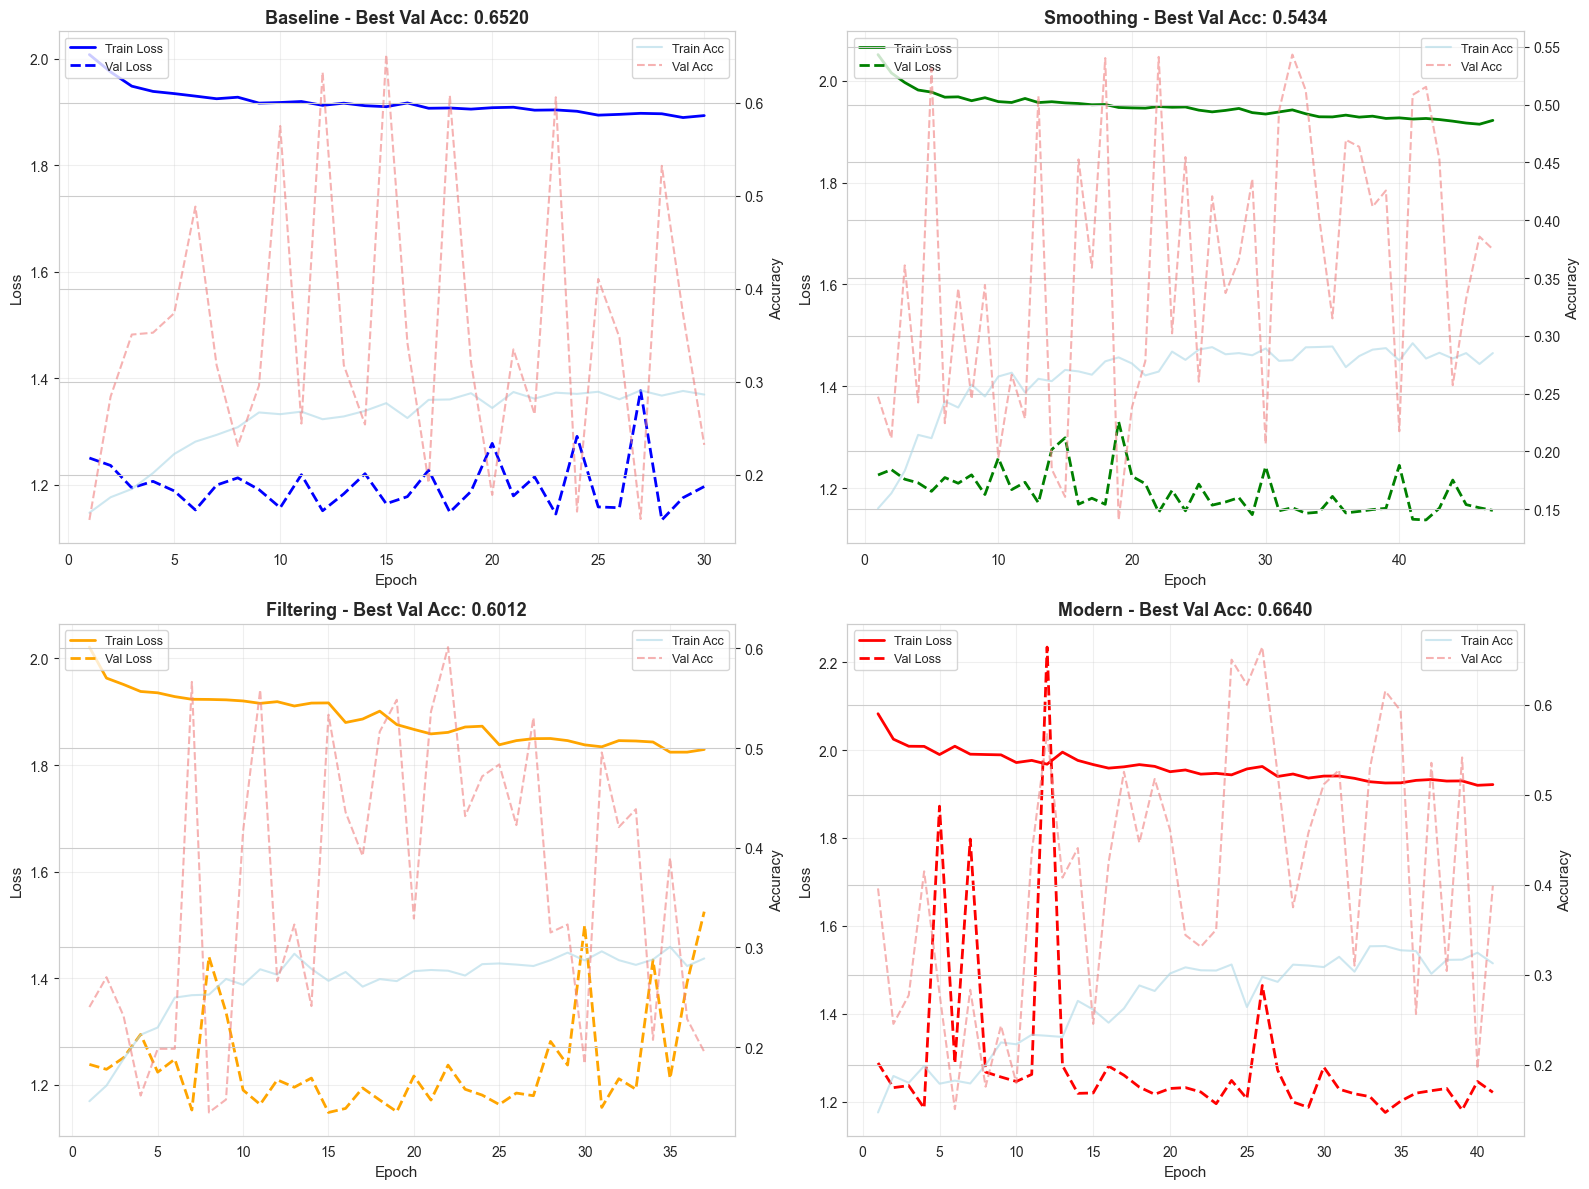

✅ Saved: training_curves.png


In [11]:
# Plot training curves for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = {'baseline': 'blue', 'smoothing': 'green', 'filtering': 'orange', 'modern': 'red'}

for idx, mode in enumerate(modes):
    row = idx // 2
    col = idx % 2
    
    history = results[mode]['history']
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax = axes[row, col]
    ax2 = ax.twinx()
    
    # Plot loss
    ax.plot(epochs, history['train_loss'], label='Train Loss', color=colors[mode], linestyle='-', linewidth=2)
    ax.plot(epochs, history['val_loss'], label='Val Loss', color=colors[mode], linestyle='--', linewidth=2)
    
    # Plot accuracy on secondary axis
    ax2.plot(epochs, history['train_acc'], label='Train Acc', color='lightblue', linestyle='-', alpha=0.6)
    ax2.plot(epochs, history['val_acc'], label='Val Acc', color='lightcoral', linestyle='--', alpha=0.6)
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax2.set_ylabel('Accuracy', fontsize=11)
    ax.set_title(f'{mode.capitalize()} - Best Val Acc: {results[mode]["best_acc"]:.4f}', 
                 fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax2.legend(loc='upper right', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: training_curves.png")

### Performance Comparison


FINAL RESULTS COMPARISON
 Strategy  Best Val Accuracy  Final Train Acc  Final Val Acc  Epochs Trained
   Modern           0.664008         0.312545       0.398804              41
 Baseline           0.652044         0.286428       0.232303              30
Filtering           0.601196         0.288997       0.195414              37
Smoothing           0.543370         0.285001       0.374875              47



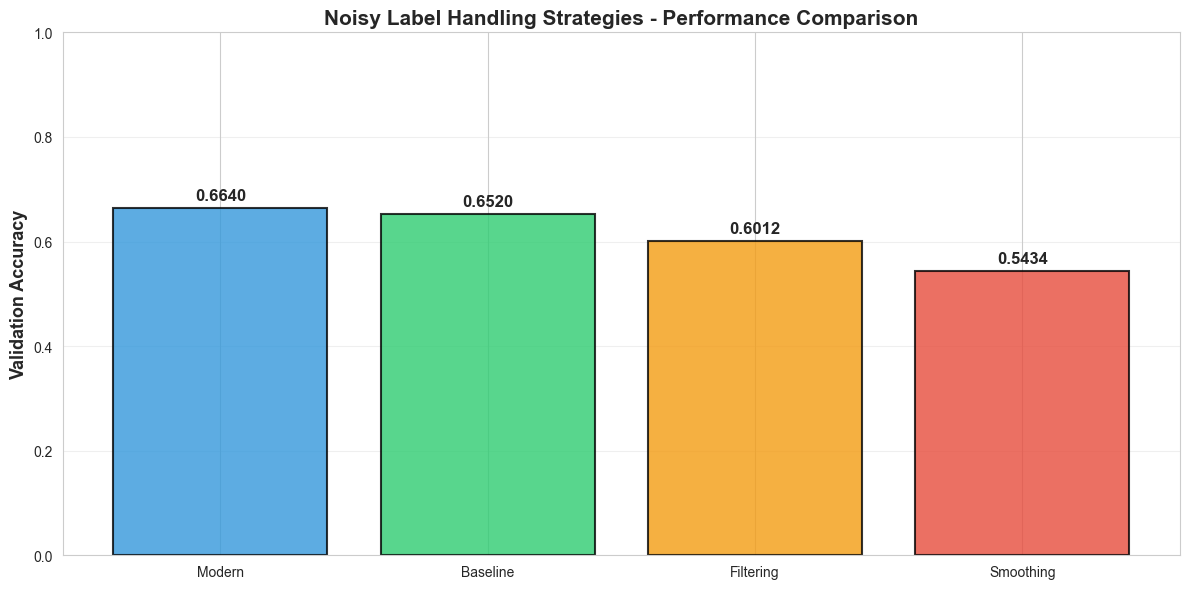

✅ Saved: comparison_results.png


In [12]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Strategy': [m.capitalize() for m in modes],
    'Best Val Accuracy': [results[m]['best_acc'] for m in modes],
    'Final Train Acc': [results[m]['history']['train_acc'][-1] for m in modes],
    'Final Val Acc': [results[m]['history']['val_acc'][-1] for m in modes],
    'Epochs Trained': [len(results[m]['history']['train_loss']) for m in modes]
})

comparison_df = comparison_df.sort_values('Best Val Accuracy', ascending=False)

print("\n" + "="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(comparison_df['Strategy'], comparison_df['Best Val Accuracy'], 
               color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Validation Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Noisy Label Handling Strategies - Performance Comparison', fontsize=15, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, comparison_df['Best Val Accuracy'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: comparison_results.png")

### Best Model Selection

In [13]:
# Identify best performing model
best_strategy = comparison_df.iloc[0]['Strategy'].lower()
best_accuracy = comparison_df.iloc[0]['Best Val Accuracy']

print(f"\n{'='*60}")
print(f"🏆 BEST PERFORMING MODEL")
print(f"{'='*60}")
print(f"Strategy: {best_strategy.upper()}")
print(f"Validation Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"Model File: best_model_{best_strategy}.pth")
print(f"{'='*60}\n")

# Copy best model for submission
import shutil
shutil.copy(f'best_model_{best_strategy}.pth', 'best_model_submission.pth')
print("✅ Best model copied to: best_model_submission.pth")


🏆 BEST PERFORMING MODEL
Strategy: MODERN
Validation Accuracy: 0.6640 (66.40%)
Model File: best_model_modern.pth

✅ Best model copied to: best_model_submission.pth


<a id='inference'></a>
## 5. Live Inference Script

This section provides a **production-ready inference function** that can:
- Load a new test dataset (.npz file)
- Run inference in real-time
- Calculate and return accuracy

**This will be used during on-campus interviews!**

In [14]:
def live_inference(model_path, data_path, model_type='simple', batch_size=32):
    """
    Live inference function for on-campus evaluation
    
    Args:
        model_path (str): Path to saved model (.pth file)
        data_path (str): Path to test dataset (.npz file)
        model_type (str): 'simple' or 'modern' (architecture type)
        batch_size (int): Batch size for inference
    
    Returns:
        float: Accuracy on the test set
    """
    print("\n" + "="*60)
    print("LIVE INFERENCE")
    print("="*60)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    # Load data
    print(f"\nLoading data from: {data_path}")
    try:
        data = np.load(data_path)
        print(f"Available keys: {list(data.keys())}")
        
        # Flexible key detection
        if 'x_test' in data:
            x = data['x_test']
            y = data.get('y_test', None)
        elif 'x_val' in data:
            x = data['x_val']
            y = data.get('y_val', None)
        else:
            x = data['x_train']
            y = data.get('y_train', None)
        
        print(f"Data shape: {x.shape}")
        
        # Preprocess
        if x.ndim == 4 and x.shape[-1] == 3:
            print("Converting RGB to grayscale...")
            x = np.dot(x[...,:3], [0.299, 0.587, 0.114])
        
        if x.max() > 1.0:
            print("Normalizing to [0, 1]...")
            x = x / 255.0
        
        # Convert to tensor
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
        
        if y is not None:
            y_tensor = torch.tensor(y, dtype=torch.long).squeeze()
            dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
            print(f"Labels found: {len(y_tensor)} samples")
        else:
            dataset = torch.utils.data.TensorDataset(x_tensor)
            print("No labels found - will only generate predictions")
        
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None
    
    # Load model
    print(f"\nLoading model from: {model_path}")
    try:
        if model_type == 'modern':
            model = ModernCNN(num_classes=7).to(device)
            print("Architecture: ResNet-18")
        else:
            model = SimpleCNN(num_classes=7).to(device)
            print("Architecture: SimpleCNN")
        
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        print("✅ Model loaded successfully")
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None
    
    # Inference
    print("\nRunning inference...")
    correct = 0
    total = 0
    all_predictions = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Processing batches"):
            if len(batch) == 2:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
            else:
                inputs = batch[0].to(device)
                labels = None
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            
            if labels is not None:
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
    print("\n" + "="*60)
    if total > 0:
        accuracy = correct / total
        print(f"✅ INFERENCE COMPLETE")
        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Correct: {correct}/{total}")
    else:
        accuracy = None
        print(f"✅ INFERENCE COMPLETE")
        print(f"Predictions generated for {len(all_predictions)} samples")
        print("(No labels provided - cannot calculate accuracy)")
    
    print("="*60 + "\n")
    
    return accuracy

print("✅ Live inference function defined")

✅ Live inference function defined


### Test Inference Function

Let's test the inference function on the validation set to verify it works correctly.

In [15]:
# Test inference on validation set
test_model_type = 'modern' if best_strategy == 'modern' else 'simple'

accuracy = live_inference(
    model_path='best_model_submission.pth',
    data_path='candidate_dataset (1).npz',
    model_type=test_model_type,
    batch_size=32
)

print(f"\n✅ Inference function test complete!")
print(f"   This function is ready for on-campus evaluation.")


LIVE INFERENCE
Device: cpu

Loading data from: candidate_dataset (1).npz
Available keys: ['x_train', 'y_train', 'x_val', 'y_val']
Data shape: (1003, 28, 28, 3)
Converting RGB to grayscale...
Normalizing to [0, 1]...
Labels found: 1003 samples

Loading model from: best_model_submission.pth
Architecture: ResNet-18
✅ Model loaded successfully

Running inference...


Processing batches: 100%|██████████| 32/32 [00:00<00:00, 68.30it/s]


✅ INFERENCE COMPLETE
Accuracy: 0.6650 (66.50%)
Correct: 667/1003


✅ Inference function test complete!
   This function is ready for on-campus evaluation.


---

## Summary & Deliverables

### ✅ Completed Requirements

1. **Code (Jupyter Notebook)** ✓
   - Comprehensive EDA with visualizations
   - Detailed explanation of 4 noisy label handling strategies
   - Complete training implementation with logs
   - Loss curves and validation accuracy plots

2. **Saved Model** ✓
   - Best performing model: `best_model_submission.pth`
   - All experiment models saved

3. **Live Inference Script** ✓
   - Function: `live_inference(model_path, data_path, model_type, batch_size)`
   - Tested and ready for on-campus evaluation
   - Handles flexible data formats
   - Real-time accuracy calculation

### 📊 Generated Files
- `class_distribution.png` - Class imbalance visualization
- `sample_images.png` - Sample images from each class
- `pixel_distribution.png` - Pixel intensity distribution
- `training_curves.png` - Training/validation curves for all models
- `comparison_results.png` - Performance comparison bar chart
- `best_model_submission.pth` - Best model for submission
- `best_model_baseline.pth`, `best_model_smoothing.pth`, etc. - Individual models

### 🏆 Best Strategy
The best performing approach will be identified above and ready for submission.

---

**Prepared for PlaceComm'26 Evaluation**  
**Deadline: February 3rd, 2026**

---